## Hotel booking

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
pd.options.display.float_format = "{:.3f}".format

import warnings
warnings.filterwarnings('ignore')

In [68]:
#Import data
df = pd.read_csv(r'E:\Scorecard prediction\data.csv')

In [3]:
#Kiểm tra các biến khuyết thiếu
data_check = 100* df.isnull().sum()/df.shape[0]
print('Dữ liệu company có lượng khuyết chiếm {}%'.format(round(data_check['company'],2)) + ' vì vậy cần loại bỏ biến này ra khỏi tệp dữ liệu')
data_check

Dữ liệu company có lượng khuyết chiếm 94.31% vì vậy cần loại bỏ biến này ra khỏi tệp dữ liệu


hotel                             0.000
is_canceled                       0.000
lead_time                         0.000
arrival_date_year                 0.000
arrival_date_month                0.000
arrival_date_week_number          0.000
arrival_date_day_of_month         0.000
stays_in_weekend_nights           0.000
stays_in_week_nights              0.000
adults                            0.000
children                          0.003
babies                            0.000
meal                              0.000
country                           0.409
market_segment                    0.000
distribution_channel              0.000
is_repeated_guest                 0.000
previous_cancellations            0.000
previous_bookings_not_canceled    0.000
reserved_room_type                0.000
assigned_room_type                0.000
booking_changes                   0.000
deposit_type                      0.000
agent                            13.686
company                          94.307


### TIỀN XỬ LÝ DỮ LIỆU

In [69]:
df = df.drop(columns = ['company'])
pass

In [70]:
NaN_replacements = {"children": 0,"country": "Unknown", "agent": 0}
df_fillna = df.fillna(NaN_replacements)
# Loại bỏ những lượt khách có tổng số khách bằng 0
abnormal = list(df_fillna[df_fillna['adults']+
                          df_fillna['children']+ 
                          df_fillna['babies'] == 0].index)
df_fillna.drop(df_fillna.index[abnormal], inplace = True) 

## Thống kê mô tả

Khách có xu hướng đăng ký ở các khách sạn trong thành phố hơn là các khách sạn resort.
Tuy vậy nhưng số lượng khách quay trở lại sử dụng dịch vụ rất ít ở cả 2 loại khách sạn


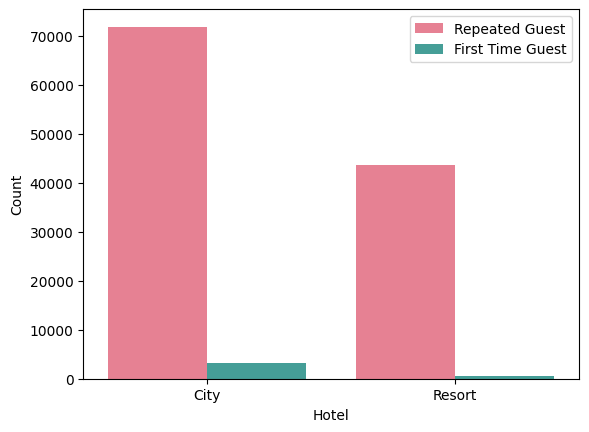

In [6]:
#Số lượng khách đăng ký lần đầu và lặp lại ở 2 khách sạn

print('Khách có xu hướng đăng ký ở các khách sạn trong thành phố hơn là các khách sạn resort.\nTuy vậy nhưng số lượng khách quay trở lại sử dụng dịch vụ rất ít ở cả 2 loại khách sạn')
ax = sns.countplot(x="is_canceled", hue="is_repeated_guest", data=df_fillna, palette = "husl")
ax.set(xlabel='Hotel', ylabel='Count')
labels = ("City", "Resort")
ax.set_xticklabels(labels)
LAB = {'Repeated Guest','First Time Guest'}
ax.legend(labels=LAB)
pass

In [7]:
df_au= df_fillna[(df_fillna['arrival_date_month'] == 'August')]
df_jan = df_fillna[(df_fillna['arrival_date_month'] == 'January')]
df_au['arrival_date_month'].count()
df_jan['arrival_date_month'].count()
pass

Du lịch có xu hướng tập trung vào các tháng hè từ 5 đến 8.
Số lượng booking cao nhất vào tháng 8 với 13861 đơn và thấp nhất vào tháng 1 với 5921


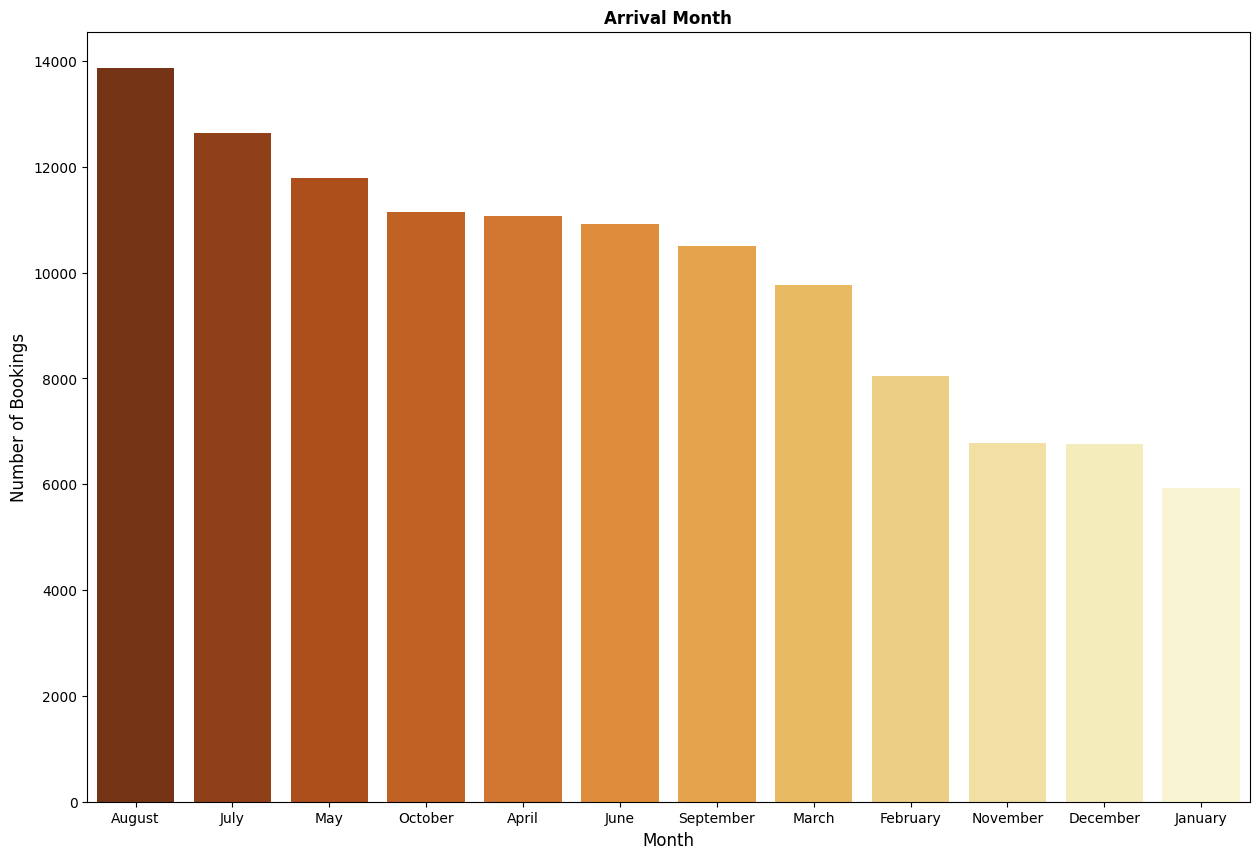

In [8]:
# Xu hướng du lịch theo tháng

print('Du lịch có xu hướng tập trung vào các tháng hè từ 5 đến 8.\nSố lượng booking cao nhất vào tháng 8 với {} đơn và thấp nhất vào tháng 1 với {}'.format(df_au['arrival_date_month'].count(), df_jan['arrival_date_month'].count()))

plt.figure(figsize=(15,10))
sns.countplot(x='arrival_date_month', data = df_fillna,
              order=pd.value_counts(df_fillna['arrival_date_month']).index, palette='YlOrBr_r')
plt.title('Arrival Month', weight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
pass

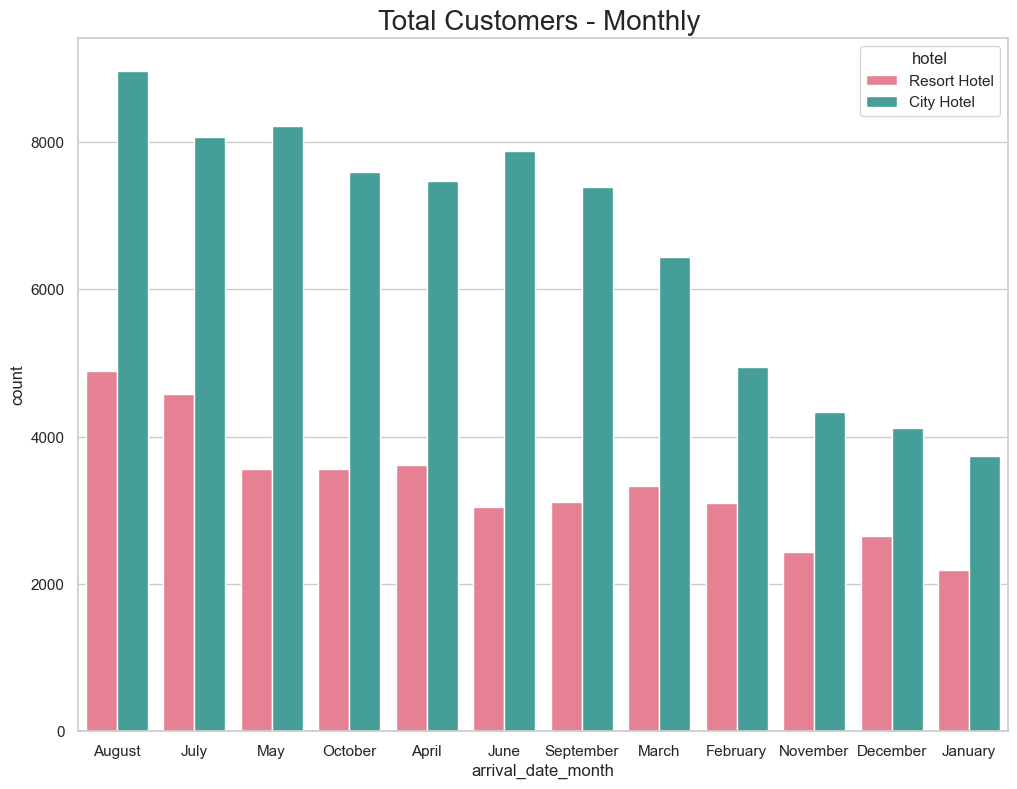

In [9]:
#Xu hướng du lịch theo tháng giữa 2 loại khách sạn

plt.figure(figsize =(12,9))
sns.set(style="whitegrid")
plt.title("Total Customers - Monthly ", fontdict={'fontsize': 20})
ax = sns.countplot(x = "arrival_date_month", hue = 'hotel', data = df_fillna, palette = 'husl',order=pd.value_counts(df_fillna['arrival_date_month']).index)

In [72]:
# Khách đến từ các vùng nào
# Số lượng khách ở các đất nước khác nhau thực sự booking vé
df_country = pd.DataFrame(df_fillna[df_fillna["is_canceled"] == 0]["country"].value_counts())

#country_data.index.name = "country"
df_country.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = df_country["Number of Guests"].sum()
df_country["Guests in %"] = round(100*df_country["Number of Guests"] / total_guests, 2)
df_country["country"] = df_country.index

# pie plot
fig = px.pie(df_country,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")

[Text(0.5, 0, 'Segment')]

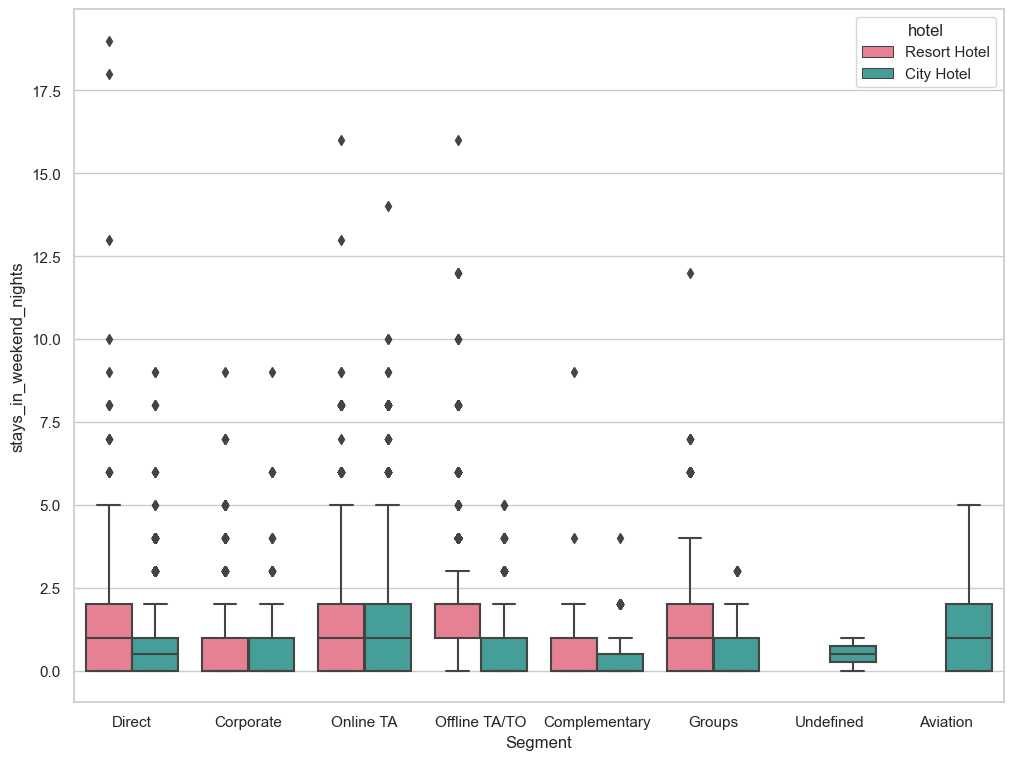

In [11]:
plt.figure(figsize = (12,9))
market_segment = sns.boxplot(x = "market_segment", y = "stays_in_weekend_nights", data = df_fillna, hue = "hotel", palette = 'husl')
market_segment.set(xlabel = 'Segment')

Lượt booking Online có số lượng đặt nhiều nhất nhưng cũng hủy cao nhất.
Ngược lại với xu hướng chung của các Segments khác, booking theo nhóm có xu hướng hủy tương đối thấp và thấp hơn đáng kể so với nhóm không hủy


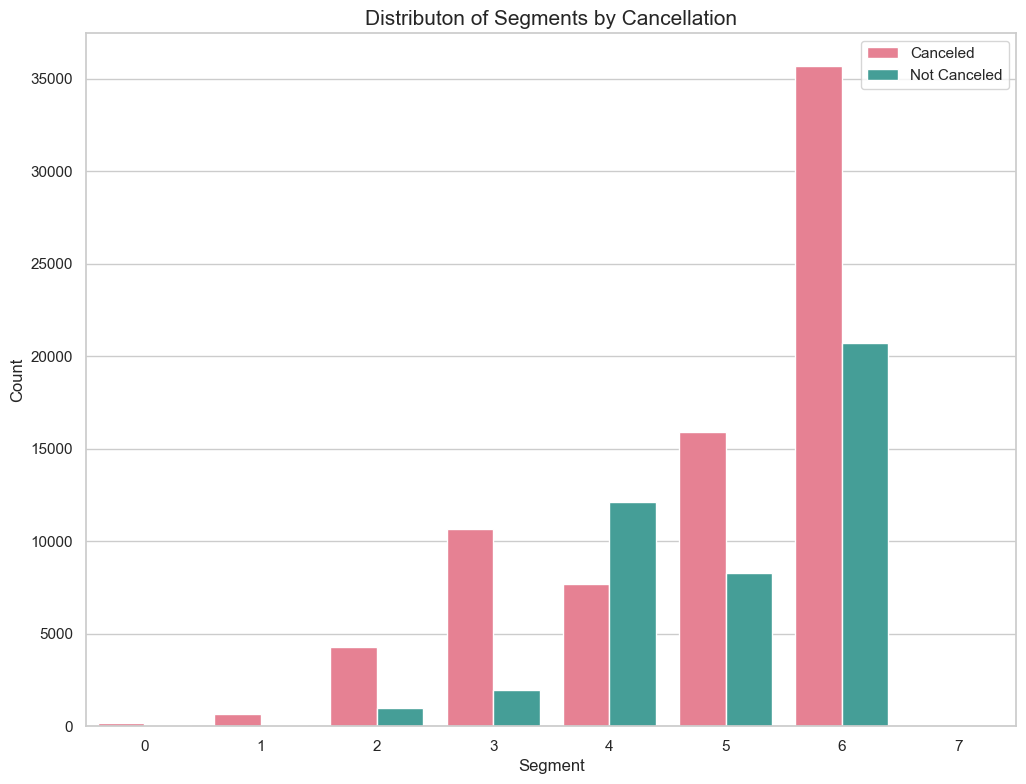

In [41]:
print("Lượt booking Online có số lượng đặt nhiều nhất nhưng cũng hủy cao nhất.\nNgược lại với xu hướng chung của các Segments khác, booking theo nhóm có xu hướng hủy tương đối thấp và thấp hơn đáng kể so với nhóm không hủy")

plt.figure(figsize = (12,9))
ax = sns.countplot(x="market_segment", hue="is_canceled", data=df_fillna, palette = 'husl')
ax.set(xlabel='Segment', ylabel='Count')
plt.title("Distributon of Segments by Cancellation", fontdict = {'fontsize':15})
LAB = {'Canceled','Not Canceled'}
ax.legend(labels=LAB)
pass

Khi lead_time vượt ngưỡng 50, khách có xu hướng hủy nhiều hơn.
Ở chiều ngược lại, những khách hàng có thời gian booking thấp chiếm số lượng lớn và có xu hướng không hủy order.


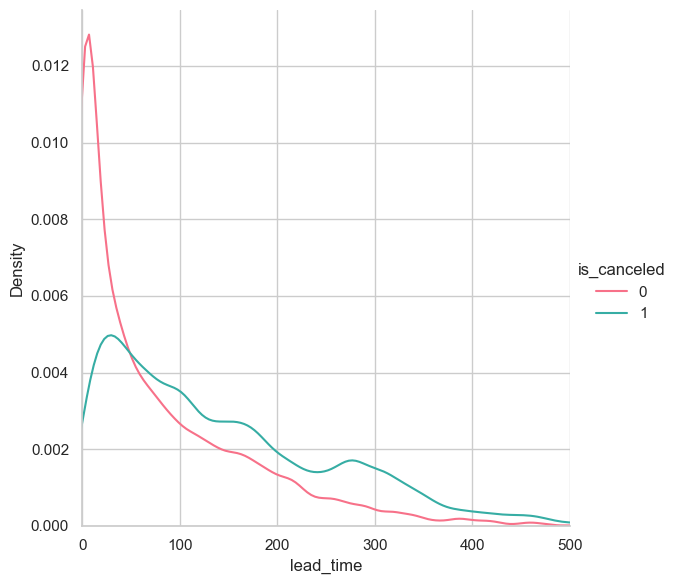

In [40]:
# Ảnh hưởng của lead time tới việc hủy booking
print("Khi lead_time vượt ngưỡng 50, khách có xu hướng hủy nhiều hơn.\nỞ chiều ngược lại, những khách hàng có thời gian booking thấp chiếm số lượng lớn và có xu hướng không hủy order.")
sns.FacetGrid(df_fillna, hue = 'is_canceled',
             height = 6,
             xlim = (0,500),
             palette= 'husl').map(sns.kdeplot, 'lead_time', shade = False).add_legend()
pass

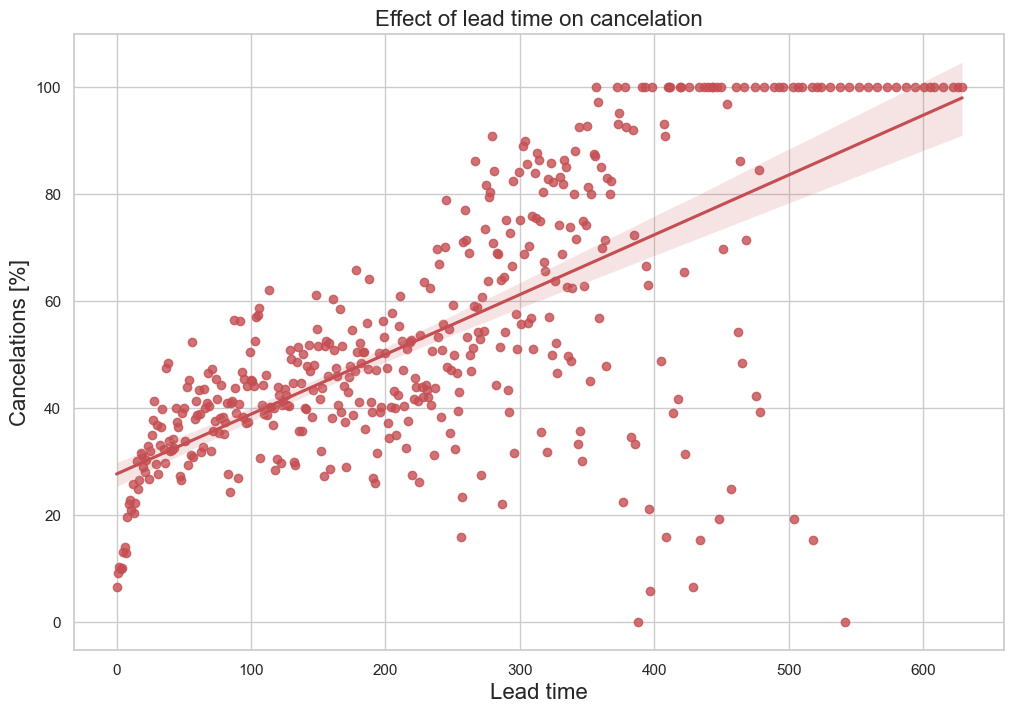

In [14]:
# Ảnh hưởng của lead time tới việc hủy booking

cancel_data = df_fillna.groupby("lead_time")["is_canceled"].describe()
cancel_data_10 = cancel_data.loc[cancel_data["count"] >= 10]

plt.figure(figsize=(12, 8))
sns.regplot(x= cancel_data_10.index, y= cancel_data_10["mean"].values * 100, color = 'r')
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()

## ENCODING DỮ LIỆU

In [15]:
labelencoder = LabelEncoder()
df_fillna['hotel'] = labelencoder.fit_transform(df_fillna['hotel'])
df_fillna['arrival_date_year'] = labelencoder.fit_transform(df_fillna['arrival_date_year'])
df_fillna['arrival_date_month'] = labelencoder.fit_transform(df_fillna['arrival_date_month'])
df_fillna['meal'] = labelencoder.fit_transform(df_fillna['meal'])
df_fillna['country'] = labelencoder.fit_transform(df_fillna['country'])
df_fillna['market_segment']= labelencoder.fit_transform(df_fillna['market_segment'])
df_fillna['distribution_channel']=labelencoder.fit_transform(df_fillna['distribution_channel'])
df_fillna['is_repeated_guest'] = labelencoder.fit_transform(df_fillna['is_repeated_guest'])
df_fillna['reserved_room_type'] = labelencoder.fit_transform(df_fillna['reserved_room_type'])
df_fillna['assigned_room_type'] = labelencoder.fit_transform(df_fillna['assigned_room_type'])
df_fillna['deposit_type'] = labelencoder.fit_transform(df_fillna['deposit_type'])
df_fillna['agent'] = labelencoder.fit_transform(df_fillna['agent'])
df_fillna['customer_type'] = labelencoder.fit_transform(df_fillna['customer_type'])
df_fillna['reservation_status'] = labelencoder.fit_transform(df_fillna['reservation_status'])
df_fillna['reservation_status_date'] = labelencoder.fit_transform(df_fillna['reservation_status_date'])

In [16]:
df_fillna['childs_total'] = df_fillna['children'] + df_fillna['babies']

In [17]:
df_fillna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119210 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119210 non-null  int32  
 1   is_canceled                     119210 non-null  int64  
 2   lead_time                       119210 non-null  int64  
 3   arrival_date_year               119210 non-null  int64  
 4   arrival_date_month              119210 non-null  int32  
 5   arrival_date_week_number        119210 non-null  int64  
 6   arrival_date_day_of_month       119210 non-null  int64  
 7   stays_in_weekend_nights         119210 non-null  int64  
 8   stays_in_week_nights            119210 non-null  int64  
 9   adults                          119210 non-null  int64  
 10  children                        119210 non-null  float64
 11  babies                          119210 non-null  int64  
 12  meal            

In [18]:
df_fillna1 = df_fillna.drop(columns = ['children','babies'])

In [35]:
num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","is_repeated_guest",
                "previous_cancellations", "previous_bookings_not_canceled","agent",
                "required_car_parking_spaces", "total_of_special_requests","adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features
X = df_fillna.drop(["is_canceled"], axis=1)[features]
y = df_fillna1["is_canceled"]

#Creating Pipeline for the full_data
num_transformer = SimpleImputer(strategy="constant")

#Creating Pipeline for both kinds of data
# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value =0)),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

In [36]:
# Chọn các classify model
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]


kfolds = 4 
split = KFold(n_splits= kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    cv_results = cross_val_score(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1,
                                 error_score='raise')

    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}, ")

DT_model cross validation accuarcy score: 0.8254 +/- 0.0003 (std) min: 0.8249, max: 0.8256, 
RF_model cross validation accuarcy score: 0.8668 +/- 0.0013 (std) min: 0.865, max: 0.8686, 
LR_model cross validation accuarcy score: 0.7962 +/- 0.0009 (std) min: 0.7953, max: 0.7975, 
XGB_model cross validation accuarcy score: 0.8459 +/- 0.0005 (std) min: 0.8449, max: 0.8463, 


In [39]:
# Enhanced RF model with the best parameters
rf_model_enh = RandomForestClassifier(n_estimators=160,
                               max_features=0.4,
                               min_samples_split=2,
                               n_jobs=-1,
                               random_state=0)

split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model_enh)])
cv_results = cross_val_score(model_pipe, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
print("Enhanced RF model cross validation accuarcy score: {}%".format(100*round(np.mean(cv_results), 4)))

Enhanced RF model cross validation accuarcy score: 86.79%
